# Exploration data analysis (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Show the first five entries of the dataset
file_path = 'Nat_Gas.csv'
nat_gas_data = pd.read_csv(file_path)

In [2]:
nat_gas_data.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [3]:
nat_gas_data.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


/var/folders/3v/xmdzd1g52j388h3t2pzt3x0r0000gn/T/ipykernel_35008/511978513.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nat_gas_data['Dates'] = pd.to_datetime(nat_gas_data['Dates'])


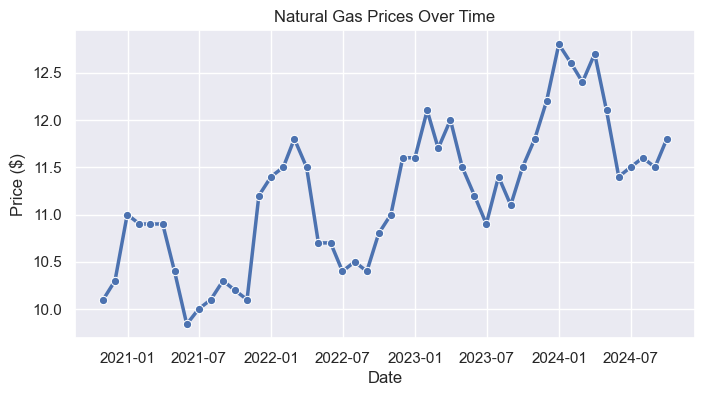

In [4]:
# Import seaborn
import seaborn as sns

# Convert 'Dates' to datetime format
nat_gas_data['Dates'] = pd.to_datetime(nat_gas_data['Dates'])

# Set seaborn style
sns.set(style="darkgrid")

# Plotting the data
plt.figure(figsize=(8, 4))
sns.lineplot(data=nat_gas_data, x='Dates', y='Prices', marker='o', color='b', linewidth=2.5)
plt.title('Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

The monthly natural gas prices appear to exhibit an increasing trend and a yearly seasonal component from 2021 to 2024. We will conduct a statistical analysis to confirm this initial observation.

# Statistical analysis

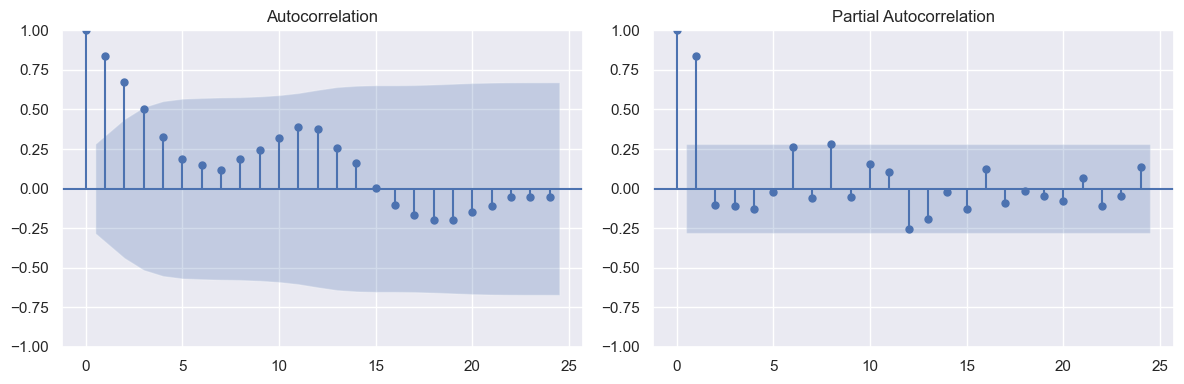

In [5]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def acf(time_series, lag):
    if lag != 0:
        time_series = time_series.diff(lag).dropna()
    # Determine the maximum allowable number of lags (50% of the sample size)
    max_lags = int(len(time_series) / 2)
    
    # Plot ACF and PACF
    plt.figure(figsize=(12, 4))
    
    # ACF plot
    plt.subplot(1, 2, 1)
    plot_acf(time_series, lags=max_lags, ax=plt.gca())
    
    # PACF plot
    plt.subplot(1, 2, 2)
    plot_pacf(time_series, lags=max_lags, ax=plt.gca(), method='ywm')
    
    plt.tight_layout()
    plt.show()

# Calculate the differenced series (first-order differencing)
time_series = nat_gas_data["Prices"]

acf(time_series, lag=0)

From the ACF and PACF plots of the original time series, the time series shows both an autoregressive (AR) and moving average (MA) component, suggesting that the dynamics of the series can be modeled using an ARMA(p, q) model for the non-seasonal part. However, due to the sinusoidal shape of the time series, we suspect the presence of both a seasonal pattern and a trend. Therefore, it is appropriate to choose a SARIMA(p, d, q)(P, D, Q, S) model, which can handle the non-seasonal ARMA components, as well as any seasonal and trend patterns.

ARMA(p, q) is useful for non-seasonal data.
SARIMA(p, d, q)(P, D, Q, S) incorporates both non-seasonal and seasonal components, where:
* $p,q$ are for the non-seasonal AR and MA terms.
* $d$ is the order of non-seasonal differencing.
* $P,Q$ are for the seasonal AR and MA terms.
* $D$ is the order of seasonal differencing.
* $S$ is the length of the seasonal cycle (e.g., 12 for monthly data with annual seasonality).

From the plots above, we can see a trend reflecting the non-stationarity property of our original time series. We can check the non-stationarity property of the natural gas prices by applying a Dicker-Fuller test.

In [6]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

def check_stationarity(timeseries): 
    # Perform the Dickey-Fuller test 
    result = adfuller(timeseries, autolag='AIC') 
    p_value = result[1] 
    print(f'ADF Statistic: {result[0]}') 
    print(f'p-value: {p_value}') 
    print('Stationary' if p_value < 0.05 else 'Non-Stationary') 

print("Check stationarity for the original time series:")
check_stationarity(nat_gas_data["Prices"])    
print("\nCheck stationarity for the residuals:")
residuals = nat_gas_data["Prices"].diff().dropna()
check_stationarity(residuals)

Check stationarity for the original time series:
ADF Statistic: 0.21807686169999216
p-value: 0.9732574388448689
Non-Stationary

Check stationarity for the residuals:
ADF Statistic: -6.844773557477351
p-value: 1.754169685294014e-09
Stationary


The Dickey-Fuller test confirms the fact that the time series was non-stationary. It becomes stationary when differenciating once. Therefore, we will chose $d = 1$.

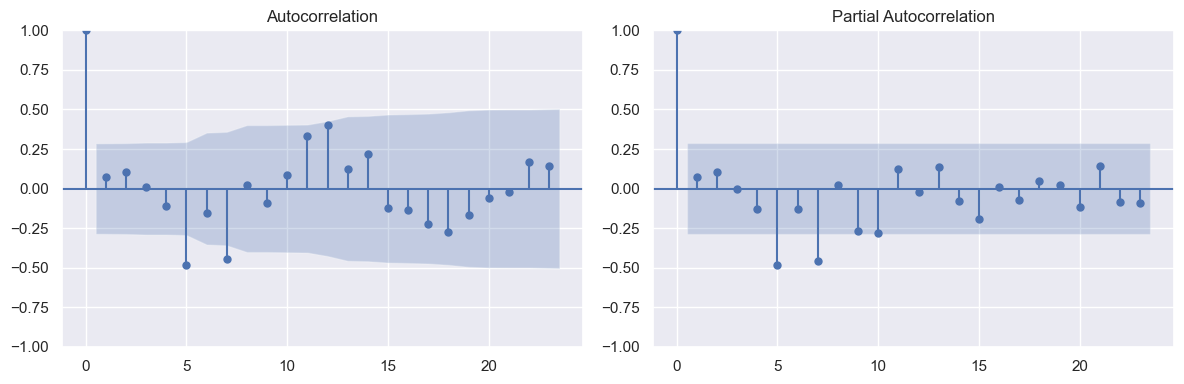

In [7]:
acf(time_series, lag=1)

Even though the differenced time series is considered stationary according to the Dickey-Fuller test (once the trend has been removed), it still exhibits some seasonal behaviors. However, we can choose the $p$ and $q$ values for the AR and MA components to be zero.

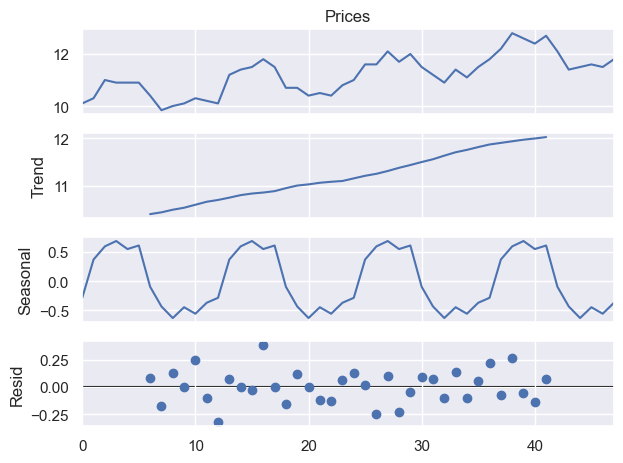

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series to observe trend, seasonality, and residuals
decomposition = seasonal_decompose(nat_gas_data['Prices'], model='additive', period=12)  # assuming yearly seasonality

# Plotting the decomposed components
fig = decomposition.plot()
plt.tight_layout()

We observe a seasonal pattern with a frequency of 12 months. Therefore, we will chose $S = 12$.

In [9]:
import pandas as pd

# Apply seasonal differencing with S=12 (e.g., for monthly data with annual seasonality)
acf(seasonal_diff, lag=12)

NameError: name 'seasonal_diff' is not defined

After applying seasonal differencing with $S=12$, the ACF and PACF plots no longer show persistent lags. Therefore, we chose $D=1$

Based on the statistical analysis, I have chosen the following parameters:
* $(p, d, q) = (0, 1, 0)$
* $(P, D, Q, S) = (0, 1, 0, 12)$

# Fit SARIMA model

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the dataset
file_path = 'Nat_Gas.csv'
nat_gas_data = pd.read_csv(file_path)

# Check the first few entries to ensure it's loaded correctly
print(nat_gas_data.head())

# Convert 'Dates' to datetime and set as index
nat_gas_data['Dates'] = pd.to_datetime(nat_gas_data['Dates'])
nat_gas_data.set_index('Dates', inplace=True)

# Set the frequency of the data to monthly
nat_gas_data = nat_gas_data.asfreq('M')

# Check data
print(nat_gas_data.head())

# Initialize and fit the SARIMAX model
try:
    sarima_model = SARIMAX(nat_gas_data['Prices'],
                           order=(0, 1, 0),
                           seasonal_order=(0, 1, 0, 12),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    sarima_result = sarima_model.fit()
except Exception as e:
    print(f"An error occurred: {e}")

# Make forecast for the next 12 months
forecast = sarima_result.get_forecast(steps=12)
forecast_index = pd.date_range(start=nat_gas_data.index[-1], periods=13, freq='M')[1:]
forecast_df = pd.DataFrame({'Forecast_Price': forecast.predicted_mean}, index=forecast_index)

# Plot the results
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4))
sns.lineplot(data=nat_gas_data, x=nat_gas_data.index, y='Prices', marker='o', color='b', linewidth=2.5, label='Actual Prices')
sns.lineplot(data=forecast_df, x=forecast_df.index, y='Forecast_Price', marker='o', color='r', linewidth=2.5, label='Forecasted Prices')
plt.title('Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


## Option 2: Linear regression and bi-regression fit

We have chosen to evaluate the SARIMA model alongside simpler models like linear regression and bi-regression with sinusoidal trends. These simpler models tend to produce smoother forecasted predictions, potentially making them less susceptible to the noise associated with the volatility in historical data. To quantitatively assess the performance of these models, we might consider using the Mean Squared Error (MSE) as a metric and averaging the results across multiple datasets. However, determining the superior model is not straightforward, even when one exhibits the lowest MSE. Sometimes, a model offering slightly less precise predictions on average may still be preferred if it offers greater interpretability and ease of understanding.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the dataset
file_path = 'Nat_Gas.csv'
nat_gas_data = pd.read_csv(file_path)
nat_gas_data['Dates'] = pd.to_datetime(nat_gas_data['Dates'])
nat_gas_data.set_index('Dates', inplace=True)
nat_gas_data = nat_gas_data.asfreq('ME')

# Create a time variable to use in the regression
nat_gas_data['Time'] = np.arange(len(nat_gas_data.index))

# Adding sinusoidal components for entire dataset
nat_gas_data['Sin_Time'] = np.sin(2 * np.pi * nat_gas_data['Time'] / 12)
nat_gas_data['Cos_Time'] = np.cos(2 * np.pi * nat_gas_data['Time'] / 12)

# Fit the linear regression
linear_model = LinearRegression()
linear_model.fit(nat_gas_data[['Time']], nat_gas_data['Prices'])
nat_gas_data['Linear_Fit'] = linear_model.predict(nat_gas_data[['Time']])

# Fit the bi-regression with sinusoidal components
bi_model = LinearRegression()
bi_model.fit(nat_gas_data[['Time', 'Sin_Time', 'Cos_Time']], nat_gas_data['Prices'])
nat_gas_data['Bi_Fit'] = bi_model.predict(nat_gas_data[['Time', 'Sin_Time', 'Cos_Time']])

# Forecast future periods
forecast_periods = 12
forecast_index = pd.date_range(start=nat_gas_data.index[-1], periods=forecast_periods + 1, freq='ME')[1:]
future_data = pd.DataFrame({
    'Time': np.arange(len(nat_gas_data.index), len(nat_gas_data.index) + forecast_periods),
    'Sin_Time': np.sin(2 * np.pi * np.arange(len(nat_gas_data.index), len(nat_gas_data.index) + forecast_periods) / 12),
    'Cos_Time': np.cos(2 * np.pi * np.arange(len(nat_gas_data.index), len(nat_gas_data.index) + forecast_periods) / 12)
}, index=forecast_index)

# Generate predictions for future data
future_data['Linear_Forecast'] = linear_model.predict(future_data[['Time']])
future_data['Bi_Forecast'] = bi_model.predict(future_data[['Time', 'Sin_Time', 'Cos_Time']])

# SARIMAX Model and forecast
sarima_model = SARIMAX(nat_gas_data['Prices'],
                       order=(0, 1, 0),
                       seasonal_order=(0, 1, 0, 12))
sarima_result = sarima_model.fit()
forecast = sarima_result.get_forecast(steps=12)
forecast_df = pd.DataFrame({'SARIMAX_Forecast': forecast.predicted_mean}, index=forecast_index)

# Plotting all forecasts
plt.figure(figsize=(8, 5))
sns.lineplot(data=nat_gas_data, x=nat_gas_data.index, y='Prices', label='Actual Prices', color='blue', marker='o')
sns.lineplot(data=nat_gas_data, x=nat_gas_data.index, y='Linear_Fit', label='Linear Fit', color='green')
sns.lineplot(data=nat_gas_data, x=nat_gas_data.index, y='Bi_Fit', label='Bi-Regression Fit', color='red')
sns.lineplot(data=future_data, x=future_data.index, y='Linear_Forecast', label='Linear Forecast', color='green', linestyle='--')
sns.lineplot(data=future_data, x=future_data.index, y='Bi_Forecast', label='Bi-Forecast', color='red', linestyle='--')
sns.lineplot(data=forecast_df, x=forecast_df.index, y='SARIMAX_Forecast', label='SARIMA Forecast', color='purple', linestyle='--')
plt.title('Natural Gas Prices and Model Forecasts')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Conclusion

The forecasted values from the SARIMA model appear to align well with the historical data trends. Nevertheless, several factors should be considered to enhance forecast reliability. Firstly, the accuracy of these forecasts is highly dependent on the appropriateness of the model parameters to the data characteristics, necessitating regular reassessments and updates as new data become available. Furthermore, the model currently relies solely on historical price data. However, natural gas prices are influenced by a myriad of factors, including geopolitical events, regulatory changes, technological progress, and shifts in demand and supply, which are not accounted for in this model. This exclusion could potentially diminish the forecast's accuracy. Moreover, the natural gas market is notoriously volatile, with prices susceptible to abrupt changes due to unforeseen market dynamics, which may not be adequately predicted by a model solely based on historical data.

While the SARIMA model serves as a robust baseline for forecasting, enhancing it with updated data, considering a combination of models, or integrating external variables would likely improve its accuracy and robustness.

Given the dataset currently only includes time-series data on natural gas prices, using advanced machine learning or deep learning models might not fully capture the complexity or add significant value beyond simpler models due to the limited feature set. Simple models, such as linear regression or bi-regression with sinusoidal components, might be more appropriate in this context.

For more intricate scenarios where additional data attributes are available, other models could be explored:

* Machine Learning Models: Techniques like regression analysis, support vector machines, or ensemble methods such as random forests and gradient boosting machines could be beneficial. These models can incorporate auxiliary variables (like economic indicators or weather conditions) that influence natural gas prices.
* Deep Learning Models: LSTM networks or other RNN variants are well-suited for sequence prediction tasks and can model the complex nonlinear relationships often present in comprehensive datasets.

Furthermore, after verifying that the provided dataset of natural gas prices did not accurately reflect reality, I have concluded that the dataset is unrealistic and designed for academic purposes. I recognize that datasets like these are purely theoretical and do not exist in real-world conditions. In practice, the signal-to-noise ratio in such datasets is very low, making it challenging to forecast the price of a volatile commodity like natural gas. Additionally, relying solely on price data is insufficient for making robust estimations.